<img src="dsa.png" alt="Drawing" />

## Introduction to Non-Parametric Modeling (Regression) using Gaussian Processes
### Data Science Africa, 2019 Accra
By `Charles I. Saidu` charles.i.saidu@gmail.com

**Affiliations**
- Baze University Abuja, www.bazeuniversity.edu.ng
- African University of Science and Technology, www.aust.edu.ng

### Data Modeling

<img src="realworld.png" alt="Drawing" style="width: 50%; height:50%"/>

- In the real, there is a function $f(x)$
- We try to learn this function $f(x)$ using data 
- However, observation process is often time corrupted by noise for each sample $x_i$ such as 
    - $ y = f(x) + \varepsilon $, $ \varepsilon \sim \mathcal{N}(0, \sigma^2)$
- **Problem**: find $f(x)$


## Latent Variable Models - Parametric Approach

- **The problem**: to find $f(x)$ 
  <img src="function_estimate.png" alt="Drawing" style="width: 50%; height:50%"/>
    
- Approach:
    - We collect dataset
    - Assume an `approximating` function class
        - Polynomial
        - Fourier expansion
        - Wavelet
        - Neural Networks
        - etc
- With a given function from the function class, optimize the parameters
- Observation process - **encodes** noise in system


## Latent Variable Model II (Parametric Approach)
- Collect Data: $(x,y)$
- Lets consider a class of polynomials $ f^*(x) = \Phi(x)^T w $

- $\Phi(x)^T = [1, x, x^2, ....x^{k+1}]$, known as the `basis` function
- $w \in \mathcal{R}^{k+1}$, $x \in \mathcal{R}^n$
- $n$ number of features in $x$   
- $k$ is the order of the polynomial, 
- Approximating $f$ with function class $f^*$ implies finding $w$
- Possible options
    - Define a loss $\mathcal{L}(f(x), w)$ and optimize via Maximum Likelihood
        - $ w^* = \displaystyle \min_w \mathcal{L}(f(x), w)$
    - Find a `posterior distribution` of $w$ by assuming a `prior` over $w$ via `Bayes rule`


## Example
- Assume True function $f(x) = xsin(x)$
- However, due to noise $e$ in data collection  we instead observed,
- $y = f(x) + e$, $e \sim \mathcal{N}(0, \sigma^2)$



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

np.random.RandomState(1)

In [2]:
#assume true function plus noise i.e. data collected is noisy 
def f_noisy(x):
    return x*np.sin(x) + np.random.rand(x.shape[0])

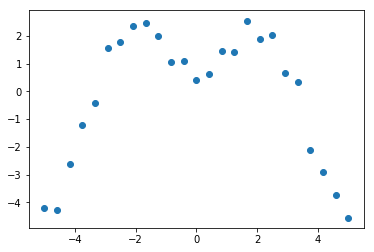

In [3]:
x= np.linspace(-5,5, 25)
y = f_noisy(x)
plt.scatter(x,y)

In [4]:
#package as a dataset
dataset = np.vstack((x,y)).T

## Visualization
- In reality data will be high dimensional, you wont be `able` to visualize very high dimensional data
`directly` to understand the structure
- For the sake of this tutorial lets visualize the data


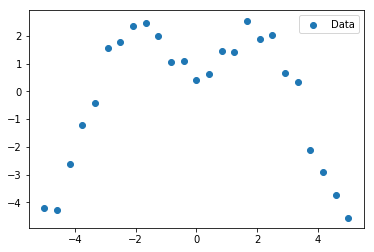

In [5]:
x = dataset[:, 0]
y = dataset[:,1]

#Visualize again to be sure
plt.scatter(x, y,  label ='Data')
plt.legend()

## Estimating $f(x)$ from data using polynomials of degree k
### Parametric Parameter estimation

- Lets estimate $f(x)$ using `Linear Regression`
- For non-linearity we project data to higher dimensional space set $k>2$ 


In [6]:
from sklearn import linear_model
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from itertools import cycle
import matplotlib;matplotlib.rcParams['figure.figsize'] = (16,12)


In [7]:
import ipywidgets as widgets
from ipywidgets import interact

In [8]:
def demo_linear(degree=1): 
    
    #little data preprocessing    
    x= dataset[:, 0]
    y = dataset[:, 1]    

    # zero mean and unit variance output y
    y -= y.mean()
    y/=y.std()


    #separate data for interpolation and Extrapolation
    start_training_series = int(.2*len(x)) 
    end_training_series = int(.8*len(x))
    x_eval = x[start_training_series:end_training_series]
    y_eval = y[start_training_series:end_training_series]
    train_index = np.random.choice(len(x_eval), int(.7 *len(x_eval)), replace=False )  #select 70 percent for training

    x_train = x_eval[train_index]
    y_train = y_eval[train_index]

    x = np.expand_dims(x, 1)
    x_train = np.expand_dims(x_train, 1)
    x_eval = np.expand_dims(x_eval, 1)
    
    
    # non-linear feature transforms with linear regression
    model = make_pipeline(PolynomialFeatures(degree), linear_model.LinearRegression()) 
    model.fit(x_train, y_train)
    
    plt.ylim(-3, 3)
    plt.xlim(-5,5)

    plt.scatter(x,y, c='gray', label="Test Points")
    plt.scatter(x_train, y_train, c ='red', label ="Training Points")
    
    model_all = model.predict(x)
    plt.plot(x, model_all, label ="All points with pol degree %d"%(degree))    

    plt.axvspan(x[0],x[start_training_series],alpha=0.3,color='gray')
    plt.axvspan(x[end_training_series],x[-1],alpha=0.3,color='gray')
    plt.legend()

In [9]:
interact(demo_linear, degree = widgets.Dropdown(options=np.arange(1,20), value = 1))

interactive(children=(Dropdown(description='degree', options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1…

<function __main__.demo_linear(degree=1)>

## Observations
- No uncertainty information in model
- Observe that in extrapolated points, we cant estimate how confident we are about prediction. Clearly we got predictions totally wrong in same cases.
- This approach assumes a `fixed` number of  model parameter. So number of parameters `does not` grow with increasing data
    - This is whats referred to as `Parametric Models`
- Model structure is specified (via the choice of `function class`) before observing data, hence its less flexible
- Higher degree leads to overfitting

## Parameter Estimation via Bayes Rule (Bayesian approach)
### Bayesian Parametric Models

- Recall
- $f(x) = \Phi(x)^T w$
- $y = f(x) + \epsilon$ , $\epsilon \sim \mathcal{N}(0,\sigma^2)$
- $x \in \mathcal{R}^D $, $D$ dimensional space


- Let assume observation corrupted by random noise $\epsilon$
- For convenience lets write $\Phi(X)$ as $\Phi$ and $\Phi(X^*)$ as $\Phi^*$ 


**Likelihood Function**
- This noise assumption together with the model directly gives rise to the likelihood, the probability density     of the observations given the parameters, which is

$$ p(\mathbf{y}|\mathbf{X}, w) = \prod_{i=1}^n p(y_i|\phi_i, w_i)  \implies \mathcal{N}(\Phi^T \mathbf{w}, σ^2I)$$ 


- $\mathbf{X}$ is the collection of the entire training dataset
- $\mathbf{y}$ entire training label
- Assume a Gaussian Prior $ \mathbf{w} \sim \mathcal{N}(\mathbf{0}, \Sigma_p)$
- Using base rule we compute the `posterior distribution` $\mathbf{w}$

$$ p(\mathbf{W}\mid\mathbf{X},\mathbf{y}) = \frac{p(\mathbf{y}\mid\mathbf{X},\mathbf{w}) \, p(\mathbf{w})}{ \int p(\mathbf{y} \mid \mathbf{X}, \mathbf{w}) d(\mathbf{w})} $$

- $p(\mathbf{y}|\mathbf{X}, \mathbf{w})$ is the likelihood of data given the parameter
- $p(\mathbf{w})$ Prior distribution of the parameter $w$
- $p(\mathbf{w}|\mathbf{X}, \mathbf{y})$ Posterior distribution of parameter given the data
- $\int p(\mathbf{y} \mid \mathbf{X}, \mathbf{w}) d(\mathbf{w})$ Marginal distribution of dataset average over parameters $\mathbf{w}$


### Inference

- Inference is done using the posterior distribution

$$p(\mathbf{y^*}|\mathbf{X}^*,\mathbf{X}, \mathbf{y} ) = \int
p(\mathbf{y^*}| \mathbf{X}^*, \mathbf{X},\mathbf{y},\mathbf{w})p(\mathbf{w} \mid p(\mathbf{W}\mid\mathbf{X},\mathbf{y}) dw.$$

## Note
- For non-gaussian likelihood and prior, close form solution to posterior `may not` be feasible hence, approximations needed
    - Variational Methods
    - Laplace
    - Sampling via Dropouts - in the case of Neural Networks

## Bayesian parameter Estimation for parametric Models


- $ p(\mathbf{y}|\mathbf{X},\mathbf{w}) = \mathcal{N}(\Phi^T \mathbf{w}, σI)$ 
- Assume `prior` distribution of $p(\mathbf{w}) = \mathcal{N}(\mathbf{0}, \Sigma)$
- Close form solution is feasible, hence
- Then posterior can be written as by `Bayes rule`. 
    - $p(\mathbf{W}\mid\mathbf{X},\mathbf{y}) \approx \mathcal{N}(\Phi^T \mathbf{w}, σ_nI)\mathcal{N}(\mathbf{0}, \Sigma_p)$ 
        - **approximation** because we didnt take into account the `intractable` marginal
- `Inference` is straight forward
    - $p(\mathbf{y^*}|\mathbf{X}^*, \mathbf{X}, \mathbf{y}) = \mathcal{N}(σ_n^{-1}\Phi^{*T}\mathbf{A}^{-1}\Phi\mathbf{y}, \Phi^{*T}\mathbf{A}^{-1} \Phi^{*} ) \implies   \int
p(\mathbf{y^*}| \mathbf{X}^*, \mathbf{X},\mathbf{y},\mathbf{w})p(\mathbf{w} \mid p(\mathbf{W}\mid\mathbf{X},\mathbf{y}) dw$

- where $\mathbf{A} = σ_n^{-2}\Phi\Phi^T + \Sigma^{-1}$

## Note

- Observa $\Phi\Phi^T$, which is a covariance of projected feature space. We can call it `Kernel` $K$


## Demo: Bayesian vs Non-Bayesian Parameter estimation
Lets Compare `Bayesian` vs a `Non-Bayesian` method

In [10]:
def demo_bayesian(degree=1):    
    #little data preprocessing    
    x= dataset[:, 0]
    y = dataset[:, 1]    

    # zero mean and unit variance output y
    y -= y.mean()
    y/=y.std()

    #separate data for interpolation and Extrapolation
    start_training_series = int(.2*len(x)) 
    end_training_series = int(.8*len(x))
    x_eval = x[start_training_series:end_training_series]
    y_eval = y[start_training_series:end_training_series]
    train_index = np.random.choice(len(x_eval), int(.7 *len(x_eval)), replace=False )  #select 70 percent for training

    x_train = x_eval[train_index]
    y_train = y_eval[train_index]

    x = np.expand_dims(x, 1)
    x_train = np.expand_dims(x_train, 1)
    x_eval = np.expand_dims(x_eval, 1)

    
    #Gineralized linear regression model
    model_lin_reg = make_pipeline(PolynomialFeatures(degree), linear_model.LinearRegression()) #regular regression
    model_lin_reg.fit(x_train, y_train)
    model_predict_lin = model_lin_reg.predict(x)
    
    plt.figure(figsize=(15,4))
    plt.suptitle("Generalized Linear Regression via (MLE) vs Bayesian Regression")    
    plt.subplot(1,2,1)
    plt.plot(x, model_predict_lin, label ="Regular Regression Pol fit with degree %d"%(degree))
    plt.ylim(-3, 3)
    plt.xlim(-5,5)
    plt.scatter(x,y, c='gray', label="Test Points")
    plt.scatter(x_train, y_train, c ='red', label="Training Points")
    plt.axvspan(x[0],x[start_training_series],alpha=0.3,color='gray')
    plt.axvspan(x[end_training_series],x[-1],alpha=0.3,color='gray')
    plt.legend()
    
    #Bayesian Regression
    plt.subplot(1,2,2)     
    model_bayesian = make_pipeline(PolynomialFeatures(degree), linear_model.BayesianRidge()) 
    model_bayesian.fit(x_train, y_train)  
    plt.ylim(-3, 3)
    plt.xlim(-5,5)

    plt.scatter(x,y, c='gray', label="Test Points")
    plt.scatter(x_train, y_train, c ='red', label="Training Points")
    
    mean, std = model_bayesian.predict(x, return_std=True)
    
    plt.plot(x, mean, label ="Bayesian Regression Pol fit with degree %d"%(degree))
    plt.fill_between(x[:,0], mean-std, mean+std, alpha=0.2, edgecolor='gray', facecolor='cyan')

    
    plt.axvspan(x[0],x[start_training_series],alpha=0.3,color='gray')
    plt.axvspan(x[end_training_series],x[-1],alpha=0.3,color='gray')
    plt.legend()

In [11]:
interact(demo_bayesian, degree = widgets.Dropdown(options=np.arange(1,20), value = 1))

interactive(children=(Dropdown(description='degree', options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1…

<function __main__.demo_bayesian(degree=1)>

**Observations:**
- We now have a `distribution` over weights $\mathbf{w}$ as opposed to `single` optimal $\mathbf{w}$ 
- Availability of uncertainty quantification because of the distribution of weight


**Advantages of this approach:**

- `Natural reguralization`(You can check this yourself), hence `less` prone to overfitting. Bayesian is good!
- Uncertainty estimates

**Not so nice:**
- Uncertainties quantifications determined by  number of parameters, choice of which is difficult to choose
- Can be `overconfident` at extrapolation points
- Still fixed number of parameters, less adaptation given growing size of data. 
- model structure still need to be specified prior to seeing the data

## Non Parametric Modeling (Regression) with Gaussian Processes


### Note
- `DOES NOT` mean there are no parameters
- Simply means model scale parameters scale with more data
- Better uncertainty quantification


### What is a Gaussian Process?

A Gaussian process (GP) is a collection of random variables, any finite number of which have a joint Gaussian distribution.

Equivalently, a GP can be seen as a stochastic process which corresponds to an infinite dimensional Gaussian distribution.

**Basic Assumption**
-  Function output points $f(x)$ whose `indexed` input sets $X$ closer in space are highly **Correlated**. And this correlation is defined by a `mean` function $\mu(\mathbf{x})$ and correlation matrix $K(\mathbf{x}, \mathbf{x})$ referred to as a `kernel`


## Marginalization and conditioning properties of the Gaussian

### Joint

Let's start with a multivariate Gaussian. Assume that we have a random variable $\mathbf{f}$ which follows a multivariate Gaussian, and we partition its dimensions into two sets, $A,B$. Then, the joint distribution can be written as:
$$
p(\underbrace{f_1, f_2, \cdots, f_s}_{\mathbf{f}_A}, \underbrace{f_{s+1}, f_{s+2}, \cdots, f_N}_{\mathbf{f}_B}) \sim \mathcal{N}(\boldsymbol \mu, \mathbf{K}).
$$
with:
$$
\boldsymbol \mu = 
    \begin{bmatrix}
        \boldsymbol \mu_A \\
      \boldsymbol \mu_B
    \end{bmatrix}
  \; \; \text{and} \; \;
    \mathbf{K} = 
    \begin{bmatrix}
         \mathbf{K}_{A A} & \mathbf{K}_{A B} \\
         \mathbf{K}_{B A} & \mathbf{K}_{B B}
    \end{bmatrix}
$$

### Marginal

And the *marginal* distribution can be written as:

$$
p(\mathbf{f}_A, \mathbf{f}_B)  \sim \mathcal{N}(\boldsymbol \mu, \mathbf{K}). \text{ Then:} \\
p(\mathbf{f}_A)  = \int_{\mathbf{f}_B} p(\mathbf{f}_A, \mathbf{f}_B) \text{d} \mathbf{f}_B =
       \mathcal{N}(\boldsymbol \mu_A, \mathbf{K}_{A A}) %\\
% p(\mathbf{f}_B)  = \int_{\mathbf{f}_A} p(\mathbf{f}_A, \mathbf{f}_B) \text{d} \mathbf{f}_A = 
%        \mathcal{N}(\boldsymbol \mu_B,\mathbf{K}_{B B})
$$

The marginalization property means that the training data that have and any (potentially infinite in number) test data $f_*$ that we have not seen (yet), follow a (potentially infinite) Gaussian distribution with mean and covariance:

$$
  \boldsymbol \mu_{\infty} = 
    \begin{bmatrix}
      \boldsymbol \mu_{\!_\mathbf{X}} \\
      \cdots \\
      \cdots
    \end{bmatrix}
  \; \; \text{and} \; \;
    \mathbf{K}_{\infty} = 
    \begin{bmatrix}
      \mathbf{K}_{\!_\mathbf{X} \!_\mathbf{X}} & \cdots \\
      \cdots & \cdots
    \end{bmatrix}
$$

where $\mathbf{X}$ is training inputs and $\mathbf{K}_{XX}$ is the covariance matrix constructing by evaluating the covariance *function* at all given inputs. 

So, in the Gaussian process case (assuming 0 mean) we have a joint Gaussian distribution of the training and the (potentially infinite!) test data:

$$
\begin{bmatrix}\mathbf{f} \\ \mathbf{f}^*\end{bmatrix} \sim \mathcal{N}\left(\mathbf{0}, \begin{bmatrix} \mathbf{K} & \mathbf{K}_\ast \\ \mathbf{K}_\ast^\top & \mathbf{K}_{\ast,\ast}\end{bmatrix}\right)
$$

Here, $\mathbf{K}_\ast$ is the (cross)-covariance matrix obtained by evaluating the covariance function in pairs of training inputs $\mathbf{X}$ and test inputs $\mathbf{X_*}$, ie.

$$
\mathbf{K}_\ast = k(\mathbf{X}, \mathbf{X}_*) .
$$

Similarly:

$$
\mathbf{K}_{\ast\ast} = k(\mathbf{X}_*, \mathbf{X}_*) .
$$

### Conditional 

Interestingly, conditioning a multivariate Gaussian to obtain the posterior distribution also yields a Gaussian:
Again, if
$$
p(\mathbf{f}_A, \mathbf{f}_B)  \sim \mathcal{N}(\boldsymbol \mu, \mathbf{K}). \; \; \text{Then:} \\
p(\mathbf{f}_A | \mathbf{f}_B) = \mathcal{N}(\boldsymbol \mu_A + \mathbf{K}_{AB} \mathbf{K}^{-1}_{BB} (\mathbf{f}_B - \boldsymbol \mu_B), \mathbf{K}_{AA} - \mathbf{K}_{AB}\mathbf{K}_{BB}^{-1}\mathbf{K}_{BA})% \\
% p(\mathbf{f}_B | \mathbf{f}_A) = \mathcal{N}(\cdots, \cdots)
$$

In the GP context this can be used for inter/extrapolation. Assume that we have a function $f$ with input domain $\mathcal{X} = \mathbb{R}$ and we set a GP prior on $f$ (so, now we use $f$ to denote function evaluations, rather than random variables). Also assume that we have a training set $\mathbf{X} = [x_1, x_2, \dots x_N]$. Then, we can condition on the function ouputs evaluated on the training set in order to perform inference for the function value at *any* input location $x_* \in \mathbb{R}$. This conditioning means finding the GP posterior *process*:

$$
p(\mathbf{f_*} | \mathbf{f_1}, \cdots, \mathbf{f_N}) = 
p(f(x_*) | f(x_1), \cdots, f(x_N)) \\
         \sim \mathcal{N}(\mathbf{K}_*^\top \mathbf{K}^{-1} \mathbf{f}\; , \; \mathbf{K}_{*,*} - \mathbf{K}_*^\top \mathbf{K}^{-1} \mathbf{K}_*)
$$

Remember, the test inputs $\mathbf{X}_*$ appear in the above expression inside $\mathbf{K}_*$ and $\mathbf{K}_{**}$.

## Noise model

As is standard in probabilistic regression, we assume a noise model. We take:

$$
y = f(x) + \epsilon
$$


where:

$$
f \sim \mathcal{GP}(0, k(x,x'))
$$

and

$$
\epsilon \sim \mathcal{N}(0,\sigma^2 I) \; \; \; \; \; \; \; \; \; (1)
$$

where non-bold symbols now denote single elements from the training vectors.

The *covariance function* $k(x,x')$ is a function which takes as inputs pairs in the input domain and returns their co-variance. By denoting $k(\mathbf{X},\mathbf{X})$ we mean that we evaluate the covariance function in the whole training set, $\mathbf{X}$, and this gives us back a covariance matrix.

The assumption about Gaussian noise says that the *training data* $(x,y) \in (\mathbf{X}, \mathbf{Y})$ are related by a function $f$ whose output is then corrupted by Gaussian noise (i.e. we have noisy observations).
The above construction, gives us the following probabilities:
\begin{equation}
p(\mathbf{y}|\mathbf{f}) = \mathcal{N}(\mathbf{y}|\mathbf{f}, \sigma^2 \mathbf{I}) 
\end{equation}

$$
p(\mathbf{f}|\mathbf{x}) = \mathcal{N}(\mathbf{f}|\mathbf{0}, K_{ff}) = (2 \pi)^{n/2} |K_{ff}|^{-1/2} \exp\left( -\frac{1}{2} \mathbf{f}^T K_{ff} \mathbf{f} \right) \text{where:} K_{ff} = k(\mathbf{x},\mathbf{x}) \; \; \; \; (2)
$$

$$
p(\mathbf{y}|\mathbf{x}) = \int p(\mathbf{y}|\mathbf{f})p(\mathbf{f}|\mathbf{x}) d\mathbf{f} = \mathcal{N}(\mathbf{y}|\mathbf{0},K_{ff}+\sigma^{2} \mathbf{I}) \; \; \; \; (3)
$$
where the last quantity is called the *marginal likelihood* and is tractable because of our choice for noise $\epsilon$ which is normally distributed.



## Predictions
Now, for a test point $x_*$ we want to compute its output on the observed space, i.e. we want to compute $y_*$. Building on the noise model and the previously shown expressions, the posterior for the test outputs is given by:

$$
\mathbf{y}^* | \mathbf{y}, \mathbf{x}, \mathbf{x_*} \sim \mathcal{N}(\boldsymbol \mu_{\text{pred}},\mathbf{K}_{\text{pred}}) \; \; \; \; (4)
$$
with  
$$
\boldsymbol \mu_{\text{pred}} = \mathbf{K}_*^\top \left[\mathbf{K} + \sigma^2 \mathbf{I}\right]^{-1} \mathbf{y}
$$
and 
$$
\mathbf{K}_{\text{pred}} = \mathbf{K}_{*,*} - \mathbf{K}_*^\top \left[\mathbf{K} + \sigma^2 \mathbf{I}\right]^{-1} \mathbf{K}_*.
$$

# Covariance functions, aka kernels

- The covariance matrices encodes our assumption about the GP. 
- By selecting a covariance function, we implicitly make an assumption about the shape of the function. 
    - For example, the smoothness can be defined by the covariance $K$  
- Even if the covariance function has a parametric form, combined with the GP it gives us a nonparametric model. In other words, the covariance function is specifying the general properties of the GP function we wish to encode, and not a specific parametric form for it.

**Example of covariance function: RBF Kernel**

Below we define two very common covariance functions: The RBF (also known as Exponentiated Quadratic or Gaussian kernel) which is differentiable infinitely many times (hence, very smooth), and the linear one:
$$
k_{RBF}(\mathbf{x}_{i,:},\mathbf{x}_{j,:}) = \sigma^2 \exp \left( -\frac{1}{2\ell^2} \sum_{d=1}^D (x_{i,d} - x_{j,d})^2\right)
$$
- where $D$ denotes the dimensionality of the input space.
- Parameters of **RBF** are:
    - $\ell$ is called *lengthscale*
    - $\sigma^2$ is the variance .
$$


## GPy Library
- The GPy Library implements Gaussian Process  
- Can be installed via pip install GPy

In [12]:
!pip install GPy

In [13]:
import GPy #imports GPy library

In [14]:
def demo_Gps(degree=1):
    #little data preprocessing    
    x= dataset[:, 0]
    y = dataset[:, 1]    

    # zero mean and unit variance output y
    y -= y.mean()
    y/=y.std()

    #separate data for interpolation and Extrapolation
    start_training_series = int(.2*len(x)) 
    end_training_series = int(.8*len(x))
    x_eval = x[start_training_series:end_training_series]
    y_eval = y[start_training_series:end_training_series]
    train_index = np.random.choice(len(x_eval), int(.7 *len(x_eval)), replace=False )  #select 70 percent for training

    x_train = x_eval[train_index]
    y_train = y_eval[train_index]

    x = np.expand_dims(x, 1)
    x_train = np.expand_dims(x_train, 1)
    x_eval = np.expand_dims(x_eval, 1)    
    
    #Bayesian Regression
    plt.subplot(1,2,1)     
    plt.suptitle("Generalized Bayesian Regression")
    model_bayesian = make_pipeline(PolynomialFeatures(degree), linear_model.BayesianRidge()) 
    model_bayesian.fit(x_train, y_train)  
    plt.ylim(-3, 3)
    plt.xlim(-5,5)

    plt.scatter(x,y, c='gray', label="Test Points")
    plt.scatter(x_train, y_train, c ='red', label="Training Points")
    
    mean, std = model_bayesian.predict(x, return_std=True)
    
    plt.plot(x, mean, label ="Bayesian Regression Pol fit with degree %d"%(degree))
    plt.fill_between(x[:,0], mean-std, mean+std, alpha=0.2, edgecolor='gray', facecolor='cyan')

    
    plt.axvspan(x[0],x[start_training_series],alpha=0.3,color='gray')
    plt.axvspan(x[end_training_series],x[-1],alpha=0.3,color='gray')
    plt.legend()
    
    
    plt.subplot(1,2,2)     
    plt.suptitle("Gaussian Process regression")
    #--- Fit a GP model and predict inter/extrapolations
    y_train = np.expand_dims(y_train,1)
    model_gp = GPy.models.GPRegression(x_train, y_train)
    K = model_gp.kern.K(x_train, x_train).copy()
    model_gp.optimize()
    mean_gp, std_gp = model_gp.predict(x)
    
    plt.ylim(-3, 3)
    plt.xlim(-5,5)
    plt.scatter(x,y, c='gray', label="Test Points")
    plt.scatter(x_train, y_train, c ='red', label="Training Points")
    
       
    plt.plot(x[:, 0], mean_gp[:,0], label ="Gaussian Process fit")
    plt.fill_between(x[:,0], mean_gp[:,0]-std_gp[:,0], mean_gp[:,0]+std_gp[:,0], alpha=0.2, edgecolor='gray', facecolor='cyan')
    
    plt.axvspan(x[0],x[start_training_series],alpha=0.3,color='gray')
    plt.axvspan(x[end_training_series],x[-1],alpha=0.3,color='gray')
    plt.legend()  


In [15]:
interact(demo_Gps, degree = widgets.Dropdown(options=np.arange(1,20), value = 1))

interactive(children=(Dropdown(description='degree', options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1…

<function __main__.demo_Gps(degree=1)>

**Observations:**
- GPs are better `Calibrated` within and outside extrapolation points. The further away into the extrapolation points the more `uncertain` the prediction
- However, for the parametric approach, `uncertainty` information is a function of number of parameters. Therefore can be `overconfident` at the extrapolation points




**Advantages of this approach GPs:**

- We now have a `distribution` over weights **functions** and necessarily weights 
- Well `calibrated` uncertainties even at extra-polation points
- `Non parametric model` as model complexity scales with data

**Some issues and possible solutions:**
- Requires to hold entire training set in memory via `kernel`. Therefore inverting the large matrix $K$ is memory and computationally expensive
    - However, these `Kernels` can be approximated via methods such as 
        - `Sparse GP` approximations, etc
    - Parallel and distributed computing can also help deal with large $K$
- Once has to decide on the choice of Kernel $K$
    - However, you can do `Deep Gaussian Processes` to learn these kernels


## Other Kernels

<img src="kernels.png" alt="Drawing" />

## Example with Real Dataset

Analysis of [AIM-94 ICU Time Series dataset](https://archive.ics.uci.edu/ml/datasets/ICU)

Analysis of AIM-94 ICU Time Series dataset

Here is the description of the patient that was observed:

8.5 month old female with biliary atresia, S/P (surgical procedure) Kasai procedure, ascending cholangitis with a history of multiple liver abscesses and portal hypertension. She was transferred to The Children's Hospital after a 15 day history of E. Coli sepsis, worsening despite antibiotic therapy and other supportive measures. She currently is in liver failure with coagulopathy. She has required mechanical ventilatory support due to the ARDS that followed the onset of sepsis.

Her admission body weight is 5 kg.

In addition to medications listed in data set, the patient receives:

Oral nystatin
Ativan 0.5 mg IV every 6 hours
Amphotericin bladder irrigation every 12 hours
Nebulized ventolin PRN
Maalox 10cc by nasogastric tube every 6 hours for gastric pH < 5


In [16]:
icu_data = pd.read_csv('./Data//aim94_map_data_for_DSA.csv',header=0)

In [17]:
icu_data.head()

,time_since_start,map
0,20,66
1,62,67
2,100,68
3,120,67
4,200,68


Now let's take a look at the patient time series. We'll focus our analysis on mean arterial pressure, the average pressure in a patient’s arteries during one cardiac cycle. The blue region from 35000 seconds up to the end of the time series will be set aside to test the predictions of our model.

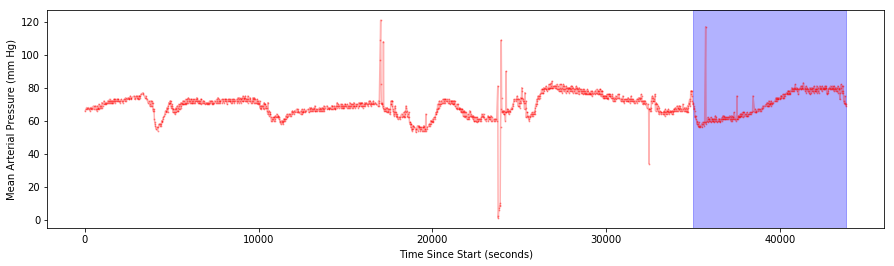

In [18]:
plt.figure(figsize=(15,4))

end_of_series = np.max(icu_data.iloc[:,0].values)

plt.plot(icu_data.iloc[:,0].values,icu_data.iloc[:,1],'-o',color='r',alpha=0.3,markersize=1)
plt.xlabel('Time Since Start (seconds)')
plt.ylabel('Mean Arterial Pressure (mm Hg)')
plt.axvspan(35000,end_of_series,alpha=0.3,color='blue')

plt.show()

In [19]:
## split data into training and test set
time_since_start = icu_data.iloc[:,0].values
map_values = icu_data.iloc[:,1].values

# we'll center the map values by substracting the mean
map_values = map_values - np.mean(map_values)

end_of_train = np.where(time_since_start >= 35000)[0][0]

train_X = np.expand_dims(time_since_start[:end_of_train],1)
train_Y = np.expand_dims(map_values[:end_of_train],1)
test_X = np.expand_dims(time_since_start[end_of_train:],1)
test_Y = np.expand_dims(map_values[end_of_train:],1)

Now we'll specify our kernel (with default hyperparameter values for now).

In [20]:
kernel = GPy.kern.RBF(input_dim=1, variance=1., lengthscale=10.)

In [21]:
m = GPy.models.GPRegression(train_X,train_Y,kernel)

In [22]:
display(m)

GP_regression.,value,constraints,priors
rbf.variance,1.0,+ve,
rbf.lengthscale,10.0,+ve,
Gaussian_noise.variance,1.0,+ve,


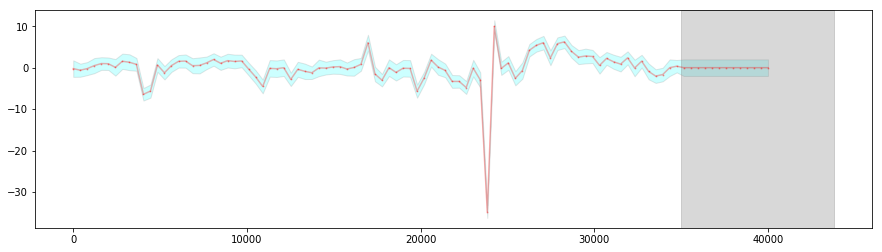

In [23]:
plt.figure(figsize=(15,4))
#Lets all points between 0 and 40,000  
all_x = np.expand_dims(np.linspace(0, 40000, 100), 1)
mean_train_y, mean_train_std =  m.predict(all_x)

plt.plot(all_x[:,0], mean_train_y[:,0],'-o',color='r',alpha=0.3,markersize=1)
plt.fill_between(all_x[:,0], mean_train_y[:,0]-mean_train_std[:,0], mean_train_y[:,0]+mean_train_std[:,0], alpha=0.2, edgecolor='gray', facecolor='cyan')
plt.axvspan(35000,end_of_series,alpha=0.3,color='gray')

In [24]:
# learn the length scale and variance parameters of GP from data
m.optimize_restarts(num_restarts = 5)

Optimization restart 1/5, f = 3790.1195640654046
Optimization restart 2/5, f = 4499.073392966136
Optimization restart 3/5, f = 4499.073392966137
Optimization restart 4/5, f = 4499.073392966136
Optimization restart 5/5, f = 4499.073392966136


In [25]:
display(m)

GP_regression.,value,constraints,priors
rbf.variance,41.374582631356695,+ve,
rbf.lengthscale,79.48814171435605,+ve,
Gaussian_noise.variance,10.396753951985401,+ve,


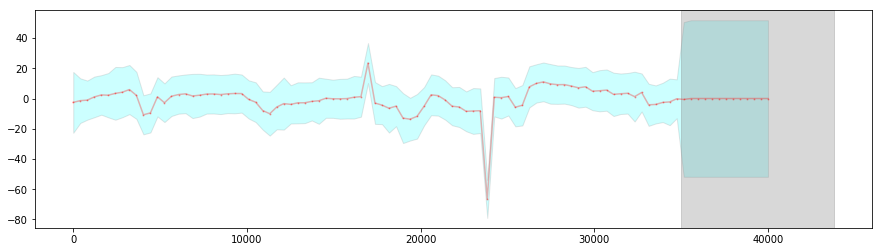

In [26]:
plt.figure(figsize=(15,4))
#Lets all points between 0 and 40,000  
all_x = np.expand_dims(np.linspace(0, 40000, 100), 1)
mean_train_y, mean_train_std =  m.predict(all_x)

plt.plot(all_x[:,0], mean_train_y[:,0],'-o',color='r',alpha=0.3,markersize=1)
plt.fill_between(all_x[:,0], mean_train_y[:,0]-mean_train_std[:,0], mean_train_y[:,0]+mean_train_std[:,0], alpha=0.2, edgecolor='gray', facecolor='cyan')
plt.axvspan(35000,end_of_series,alpha=0.3,color='gray')

## General Notes
- GPs give much better calibrated uncertainties within interpolated points
- They give realistic uncertainty in extrapolation points instead of being `blindly` confident

- These make them very useful in critical application areas where bad decision can lead to damaging consequences
- They are also very good models when doing 
    - Active learning
    - Bayesian Optimization
    - etc
    


## References and Additional readings
- Damianou, Andreas "Gaussian process introductory tutorial in Python" (https://t.co/Edp0UGT7Zr?amp=1): Great tutorials with code from scratch
- C. E. Rasmussen & C. K. I. Williams "Gaussian Processes for Machine Learning" - Great book on GPs
- Lecture note from Lehel Csato (http://www.cs.ubbcluj.ro/~csatol/) 
- Lecture notes from Neil Lawrence (http://inverseprobability).com

### Appreciations
- Thanks to Andreas Damianou (http://www.andreasdamianou.com) for letting me used part of his notebooks.
- Thanks to Mathew Mayhew for his contributions `Twitter: @DataForager`

## Take work work
- I have put together some dataset in the /Data folder. Play with them to get a better understanding of these GPs

## Thanks!